<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Práctico </h1>
<h3> Análisis y Visualización de Datos - 2020 </h3>

Durante este práctico vamos a trabajar sobre el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato. Este índice mide en detalle lo que entendemos como libertad, utilizando 79 indicadores de libertad personal y económica en distintos aspectos, hasta obtener un hermoso numerito del 1 al 10.

Las variables más importantes sobre las que trabaja el dataset son:

* Rule of Law
* Security and Safety
* Movement
* Religion
* Association, Assembly, and Civil Society
* Expression and Information
* Identity and Relationships
* Size of Government
* Legal System and Property Rights
* Access to Sound Money
* Freedom to Trade Internationally
* Regulation of Credit, Labor, and Business

Nosotros centrarermos nuestro análisis en variables relacionadas a *Identity and Relationships* en paises de Latinoamérica, y los compararemos con las estadísticas globales. La pregunta a responder es simple: **¿Qué niveles de libertad se viven en Latinoamérica, especificamente en cuanto libertades de indentidad?**. Sin embargo, para hacer un análisis de los datos tenemos que platear también estas sub preguntas:

1. ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.
2. ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?
3. En este estudio, la libertad se mide con un estimadores principal: *hf_score* que hace referencia a Human Freedom, que a su vez está calculado en base a dos otros estimadores *ef_score*, para Economic Freedom y *pf_score*, para Personal Freedom. Estos tres estimadores, ¿se relacionan de la misma manera con la libertad de identidad?

Inicialmente, en toda exploración de datos tenemos muy poca información a priori sobre el significado de los datos y tenemos que empezar por comprenderlos. Les proponemos los siguientes ejercicios como guía para comenzar esta exploración.

In [2]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn

In [3]:
seaborn.__version__

'0.10.1'

In [4]:
BLUE = '#35A7FF'
RED = '#FF5964'
GREEN = '#6BF178'
YELLOW = '#FFE74C'

In [5]:
# Con esto hacemos los gráficos más grandes, adecuados para las presentaciones.
seaborn.set_context(context='talk', font_scale=1.2)

Si un archivo está disponible en la web, podemos leerlo con pandas utilizando su URL sin necesidad de descargarlo.

In [6]:
dataset = pandas.read_csv(
    'https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2019.csv')
dataset.shape

(1620, 120)

In [7]:
dataset.columns  # Way too many columns!

Index(['year', 'ISO_code', 'countries', 'region', 'hf_score', 'hf_rank',
       'hf_quartile', 'pf_rol_procedural', 'pf_rol_civil', 'pf_rol_criminal',
       ...
       'ef_regulation_business_adm', 'ef_regulation_business_bureaucracy',
       'ef_regulation_business_start', 'ef_regulation_business_bribes',
       'ef_regulation_business_licensing', 'ef_regulation_business_compliance',
       'ef_regulation_business', 'ef_regulation', 'ef_score', 'ef_rank'],
      dtype='object', length=120)

Por suerte las columnas tienen un prefijo que nos ayuda a identificar a qué sección pertenecen. Nos quedamos sólo con las que comienzan con *pf_indentity*, junto con otras columnas más generales

In [8]:
score_cols = [col for col in dataset.columns if 'pf_identity' in col] + [
    'pf_score', # Personal Freedom (score)
    'pf_rank', # Personal Freedom (rank)
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

important_cols = ['year', 'ISO_code', 'countries', 'region'] + score_cols

In [9]:
dataset[important_cols]

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0,10,10,10,7.5,5.8,8.01,46,7.67,30,7.84,38
1,2017,DZA,Algeria,Middle East & North Africa,-,0,0,0,0,0,5.2,146,4.77,159,4.99,155
2,2017,AGO,Angola,Sub-Saharan Africa,10,0,0,0,5,5,5.98,121,4.83,158,5.4,151
3,2017,ARG,Argentina,Latin America & the Caribbean,10,10,10,10,10,10,8.04,41,5.67,147,6.86,77
4,2017,ARM,Armenia,Caucasus & Central Asia,7,10,10,10,7.5,8.2,7.15,72,7.7,27,7.42,54
5,2017,AUS,Australia,Oceania,7,10,10,10,10,9,9.16,12,8.07,9,8.62,5
6,2017,AUT,Austria,Western Europe,10,10,10,10,10,10,9.25,8,7.71,26,8.48,13
7,2017,AZE,Azerbaijan,Caucasus & Central Asia,0,10,10,10,7.5,5.8,6.1,119,6.34,116,6.22,121
8,2017,BHS,Bahamas,Latin America & the Caribbean,-,10,10,10,10,10,7.87,48,7.25,58,7.56,48
9,2017,BHR,Bahrain,Middle East & North Africa,-,10,10,10,0,5,5.91,126,7.35,50,6.63,95


Si analizamos los tipos, vemos que casi todas las columnas se leen como objetos debido a que los valores nulos están marcados con `-`. Los vamos a eliminar y volveremos a convertir las columnas con puntajes a tipo numérico.

In [10]:
dataset = dataset[important_cols].replace('-', numpy.nan)
for score_col in score_cols:
    dataset[score_col] = pandas.to_numeric(dataset[score_col])
dataset = dataset.replace('Latin America & the Caribbean','LatAm')
dataset.head()

,year,ISO_code,countries,region,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_score,ef_rank,hf_score,hf_rank
0,2017,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,7.67,30.0,7.84,38.0
1,2017,DZA,Algeria,Middle East & North Africa,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,4.77,159.0,4.99,155.0
2,2017,AGO,Angola,Sub-Saharan Africa,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,4.83,158.0,5.40,151.0
3,2017,ARG,Argentina,LatAm,10.0,10.0,10.0,10.0,10.0,10.0,8.04,41.0,5.67,147.0,6.86,77.0
4,2017,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,7.5,8.2,7.15,72.0,7.70,27.0,7.42,54.0


In [11]:
dataset.dtypes

year                        int64
ISO_code                   object
countries                  object
region                     object
pf_identity_legal         float64
pf_identity_sex_male      float64
pf_identity_sex_female    float64
pf_identity_sex           float64
pf_identity_divorce       float64
pf_identity               float64
pf_score                  float64
pf_rank                   float64
ef_score                  float64
ef_rank                   float64
hf_score                  float64
hf_rank                   float64
dtype: object

# Parte 1

Luego de las clases del primer fin de semana, ya tenemos las herramientas para responder las siguientes preguntas:

## 1. Estadísticos descriptivos

  1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.

In [12]:
df = dataset
df = df.drop(['ISO_code', 'countries', 'region'], axis=1) # drop non numeric variables
max_row = df.max()
min_row = df.min()
ranges = max_row - min_row
range_df = pandas.DataFrame({'Min' : min_row,'Max' : max_row, "Range" : ranges})
range_df

,Min,Max,Range
year,2008.00,2017.00,9.00
pf_identity_legal,0.00,10.00,10.00
pf_identity_sex_male,0.00,10.00,10.00
pf_identity_sex_female,0.00,10.00,10.00
pf_identity_sex,0.00,10.00,10.00
pf_identity_divorce,0.00,10.00,10.00
pf_identity,0.00,10.00,10.00
pf_score,2.22,9.56,7.34
pf_rank,1.00,162.00,161.00
ef_score,2.58,9.11,6.53


  2. Para cada país, tenemos varias realizaciones para cada variable *pf_identity* y *hf_score*. Si queremos comparar un país con otro, ¿cuál es la manera adecuada de hacerlo? Por ejemplo, ¿nos quedamos con un único valor? ¿o comparamos todos los valores? ¿usamos el promedio? ¿usamos la mediana? 

RESPUESTA: (Pablo)
Vamos a usar los datos a través del tiempo comparando dato con dato y en los casos en que ay que sacar conclusiones respecto a intervalos especificos vamos a usar el promedios.


2. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. Usar la respuesta del punto anterior para justificar si la comparación es válida o no.

In [13]:
# mean, median and standard deviation for the world
# Ser consistente como tratamos los intervalos de tiempo ????  
grouped = dataset.groupby(['region'])
LatAm = grouped.get_group('LatAm')
descriptive_df = pandas.DataFrame({'index' : ['pf_identity_mean','pf_identity_std','pf_identity_median', \
                                              'hf_score_mean','hf_score_std','hf_score_median'], \
                                   'LatAm' : [ LatAm.pf_identity.mean(), \
                                              LatAm.pf_identity.std(), \
                                              LatAm.pf_identity.median(), \
                                              LatAm.hf_score.mean(), \
                                              LatAm.hf_score.std(), \
                                              LatAm.hf_score.median()], \
                                   "World" : [ dataset.pf_identity.mean(), \
                                              dataset.pf_identity.std(), \
                                              dataset.pf_identity.median(), \
                                              dataset.hf_score.mean(), \
                                              dataset.hf_score.std(), \
                                              dataset.hf_score.median()]})
descriptive_df.set_index('index') # make it a little prettier

,LatAm,World
index,,
pf_identity_mean,8.582171,7.280649
pf_identity_std,1.875832,3.181577
pf_identity_median,10.000000,8.800000
hf_score_mean,7.036977,6.978214
hf_score_std,0.634897,1.056239
hf_score_median,7.020000,6.900000


  * ¿Tiene sentido calcular la moda? *RESPUESTA*
  * ¿Cómo pueden sanearse los valores faltantes? *RESPUESTA*
  * ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? Los outliers, ¿son globales o por grupo? ¿Los eliminaría del conjunto de datos? RESPUESTA

## OUTLIERS
Dos formas de identificarlos:
* usando 1.5*IQR
* usando 2.5 * standard deviation from the mean

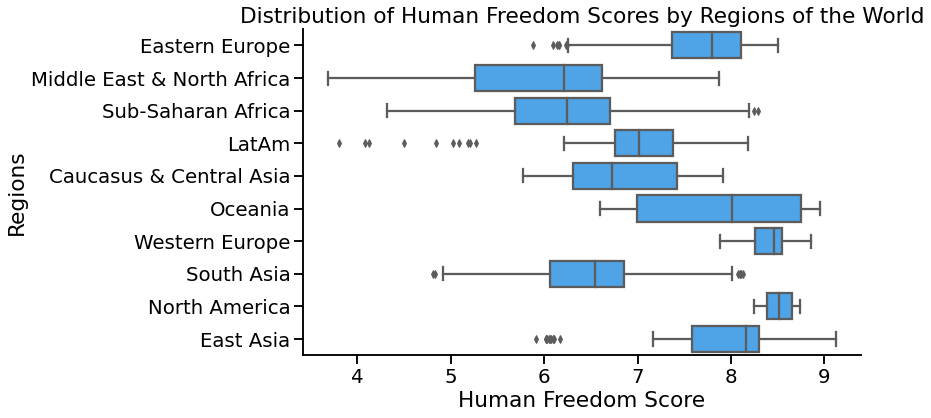

In [14]:
# The best way to quickly visualize outliers is with the box and whiskers plot (grafico de caja)
plt.figure(figsize=(10,6))
seaborn.boxplot(data=dataset,
                x='hf_score', y= 'region',
                color=BLUE)
plt.ylabel('Regions')
plt.xlabel('Human Freedom Score')
plt.title('Distribution of Human Freedom Scores by Regions of the World')
seaborn.despine()

As indicated by the black diamods situated left of the left whisker, LatAm has many outliers, or values 

### Finding outliers method 1: usando 1.5*IQR

In [15]:
# Outliers World ~~ [ 0.25= Q1, 0.5 = Q2 (median), 0.75= Q3 ]
quartiles = dataset.hf_score.quantile([0.25,0.5,0.75]).round(2)
quartiles = quartiles.tolist()
IQR = quartiles[2]-quartiles[0] #calculate the interquartile range
1.5*IQR # for all outliers will be this many away from the median

2.3999999999999995

In [16]:
# Outliers LatAm~~ [ 0.25= Q1, 0.5 = Q2 (median), 0.75= Q3 ]
quartiles_latam = LatAm.hf_score.quantile([0.25,0.5,0.75])
quartiles_latam = quartiles_latam.tolist()
IQR_latam = quartiles_latam[2]-quartiles_latam[0] #calculate the interquartile range
print("Any value ",1.5*IQR_latam," above the third quartile or below the first quartile it would be considered an outlier.") # for all outliers will be this many away from the median

Any value  0.9225000000000003  above the third quartile or below the first quartile it would be considered an outlier.


### Finding outliers method 2: usando 2.5 * standard deviation from the mean

In [17]:
def clean_outliers(dataset, column_name):
    """Returns dataset removing the outlier rows from column @column_name."""
    interesting_col = dataset[column_name]
    # Here we can remove the outliers from both ends, or even add more restrictions.
    mask_score_outlier = (
        numpy.abs(interesting_col - interesting_col.mean()) <= (2.5 * interesting_col.std()))
    return dataset[mask_score_outlier]

# World outliers
data = clean_outliers(dataset, "hf_score").hf_score
print("Filas removidas", len(dataset) - len(data))
print("Human Freedom máximo considerado", data.max())
print("Human Freedom minimo considerado", data.min())

Filas removidas 93
Human Freedom máximo considerado 9.12
Human Freedom minimo considerado 4.34


In [18]:
# Outliers in Latin America y Caribe
data2 = clean_outliers(LatAm, "hf_score").hf_score
print("Filas removidas", len(LatAm) - len(data2))
print("Human Freedom máximo considerado", data2.max())
print("Human Freedom minimo considerado", data2.min())

Filas removidas 12
Human Freedom máximo considerado 8.18
Human Freedom minimo considerado 6.21


Al final no sacamos los outliers... ?  --------- Brandon ------

## 2. Agregación de datos  - Pablo & Karen

1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.

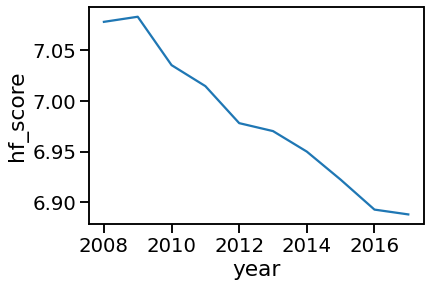

In [33]:
data_ = dataset.groupby("year").mean().reset_index()
ax = seaborn.lineplot(x="year", y="hf_score", data=data_)


2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?


Pista: hay gráficos de seaborn que permiten generar visualizaciones para cada valor de una variable categórica, en este caso, las distintas regiones.

Sólo por curiosidad, graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

['Caucasus & Central Asia', 'East Asia', 'Eastern Europe', 'LatAm', 'Middle East & North Africa', 'North America', 'Oceania', 'South Asia', 'Sub-Saharan Africa', 'Western Europe']


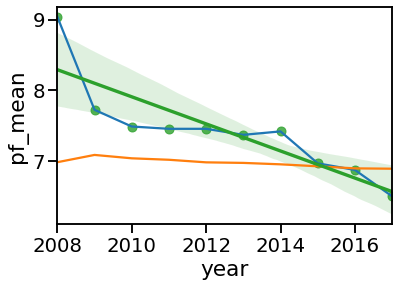

In [57]:
regions = list(set(dataset['region'].to_list()))
regions = list(numpy.sort(regions))
print(regions)
plots=[]
region = 'LatAm'
by_region = dataset.groupby(['region']).get_group(region)

#esto puede ser get_means_by(my_filter, region)
#y en el groupby haces str(my_filter)
def get_means_by_region(region):
    #para una region
    by_region = dataset.groupby(['region']).get_group(region)
    for year in years:
        grouped = by_region.groupby(['year'])
        year_data = grouped.get_group(year)
        pf_identities= year_data['pf_identity'].to_list()
        pf_identities=[x for x in pf_identities if str(x) != 'nan']
        pf_identity_mean=numpy.mean(pf_identities)
        pf_data[year]=pf_identity_mean
        
        hf_scores = year_data['hf_score'].to_list()
        hf_scores=[x for x in hf_scores if str(x) != 'nan']
        hf_score_mean = numpy.mean(hf_scores)
        hf_data[year]=hf_score_mean
    
        pf = pandas.DataFrame(pf_data.items(), columns=['year', 'pf_mean'])
        hf = pandas.DataFrame(hf_data.items(), columns=['year', 'hf_mean'])

        return pf, hf
        
#el amarillo es bx
pf_cca, hf_cca = get_means_by_region('Caucasus & Central Asia')
pf_cca_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_cca)
hf_cca_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_cca)
#thanks, i hate it
caa_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_cca)



TOD0: Cleanup... usar grid, que tengan la misma escala para que las gráficas sean analizables una al lado de la otra.
Inspiración:
<code
countries = ['Argentina', 'Brazil', 'Mexico', 'Bolivia',
             'Uruguay', 'Peru', 'Colombia', 'Venezuela']
g = seaborn.FacetGrid(dataset, col="countries",
                      margin_titles=True, aspect=2, col_wrap=2,
                      col_order=countries)
g.map(seaborn.lineplot, "year", "ef_score", color=BLUE)
g.map(seaborn.lineplot, "year", "pf_score", color=RED)
g.set(xlim=(2008, 2016))

print('Puntajes de libertad para América Latina');
>

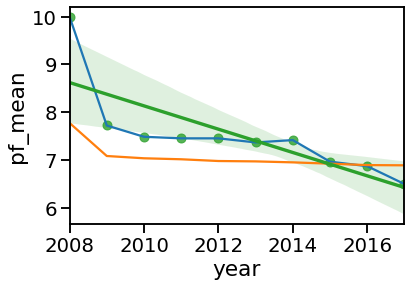

In [58]:
pf_ea, hf_ea = get_means_by_region('East Asia')
pf_ea_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_ea)
hf_ea_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_ea)
ea_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_ea)


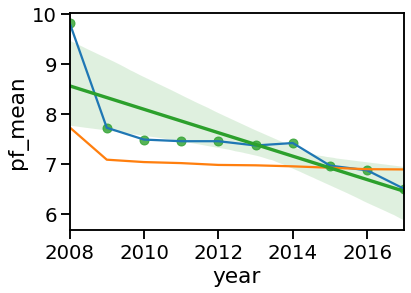

In [59]:
pf_ee, hf_ee = get_means_by_region('Eastern Europe')
pf_ee_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_ee)
hf_ee_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_ee)
ee_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_ee)


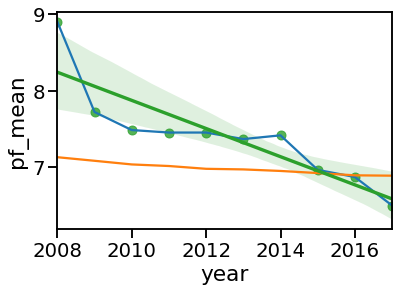

In [60]:
pf_lat, hf_lat = get_means_by_region('LatAm')
pf_lat_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_lat)
hf_lat_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_lat)
lat_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_lat)


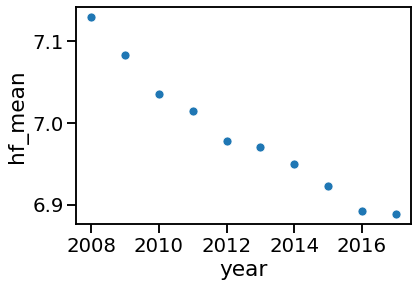

In [61]:
hf_lat_scat = seaborn.scatterplot(x="year", y="hf_mean", data=hf_lat)

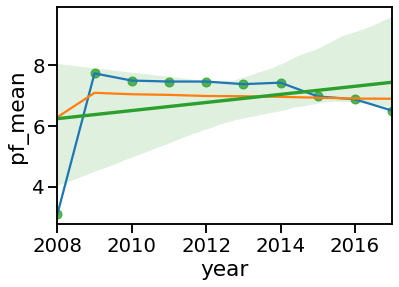

In [62]:
pf_me, hf_me = get_means_by_region('Middle East & North Africa')
pf_me_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_me)
hf_me_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_me)
me_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_me)


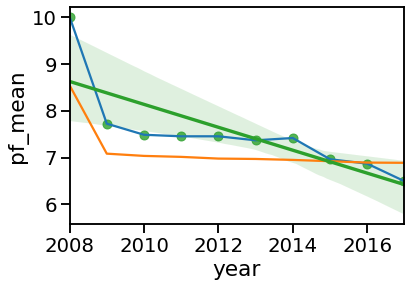

In [63]:
pf_na, hf_na = get_means_by_region('North America')
pf_na_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_na)
hf_na_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_na)
na_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_na)


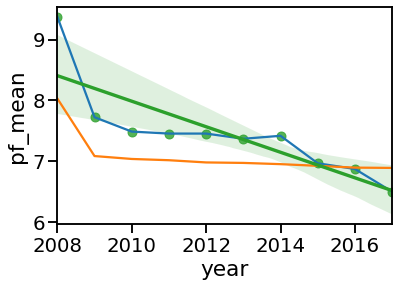

In [64]:
pf_oc, hf_oc = get_means_by_region('Oceania')
pf_oc_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_oc)
hf_oc_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_oc)
oc_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_oc)


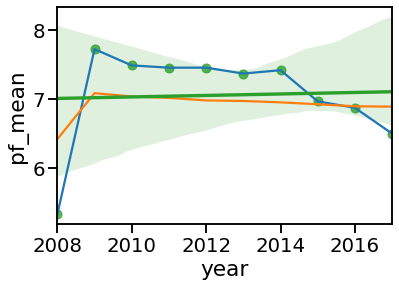

In [65]:
pf_sa, hf_sa = get_means_by_region('South Asia')
pf_sa_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_sa)
hf_sa_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_sa)
sa_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_sa)


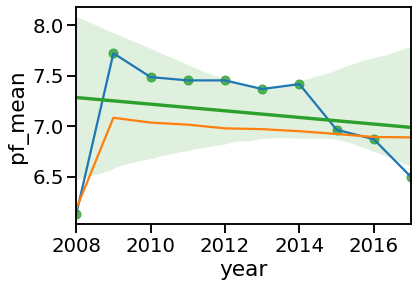

In [66]:
pf_saa, hf_saa = get_means_by_region('Sub-Saharan Africa')
pf_saa_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_saa)
hf_saa_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_saa)
saa_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_saa)


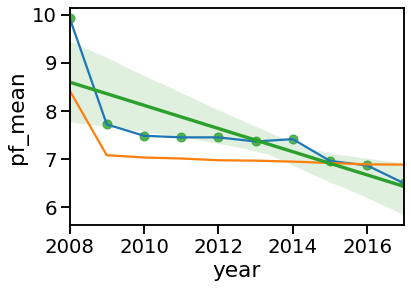

In [67]:
pf_we, hf_we = get_means_by_region('Western Europe')
pf_we_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_we)
hf_we_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_we)
we_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_we)


#Teniendo en cuenta lo que vemos en los gráficos por región vs el gráfico de tendencias global
#vemos que si bien no todas las regiones en particular decrecen como la pendiente de la tendencia global indica
#la mayoría sí decrece.

#3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica 
#para tratar de explicar la tendencia de la variable *pf_identity* en la región. 
#¿Cómo seleccionarion los países relevantes a esa tendencia?

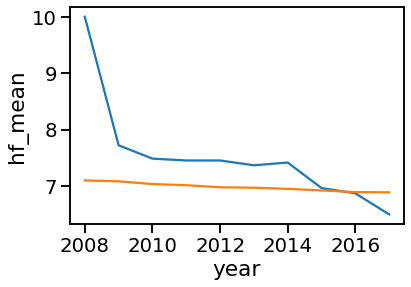

In [68]:
#venezuela, chile, uruguay, argentina.
#seaborn.regplot(x="year",y="hf_mean",data = hf_lat)
def get_means_by_country(country):
    #para una region
    by_region = dataset.groupby(['countries']).get_group(country)
    for year in years:
        grouped = by_region.groupby(['year'])
        year_data = grouped.get_group(year)
        pf_identities= year_data['pf_identity'].to_list()
        pf_identities=[x for x in pf_identities if str(x) != 'nan']
        pf_identity_mean=numpy.mean(pf_identities)
        pf_data[year]=pf_identity_mean
        
        hf_scores = year_data['hf_score'].to_list()
        hf_scores=[x for x in hf_scores if str(x) != 'nan']
        hf_score_mean = numpy.mean(hf_scores)
        hf_data[year]=hf_score_mean
    
        pf = pandas.DataFrame(pf_data.items(), columns=['year', 'pf_mean'])
        hf = pandas.DataFrame(hf_data.items(), columns=['year', 'hf_mean'])

        return pf, hf
        
#el amarillo es bx
pf_arg, hf_arg = get_means_by_country('Argentina')
pf_arg_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_arg)
hf_arg_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_arg)



In [74]:
#no entendemos este código
""""
countries = ['Argentina','Uruguay', 'Chile', 'Venezuela']
g = seaborn.FacetGrid(dataset, col="countries",
                      margin_titles=True, aspect=2, col_wrap=2,
                      col_order=countries)
g.map(seaborn.lineplot, "year", "pf_score", color=BLUE)
g.map(seaborn.lineplot, "year", "hf_score", color=RED)
g.set(xlim=(2008, 2017))

print('Puntajes de libertad para América Latina');
"""

'"\ncountries = [\'Argentina\',\'Uruguay\', \'Chile\', \'Venezuela\']\ng = seaborn.FacetGrid(dataset, col="countries",\n                      margin_titles=True, aspect=2, col_wrap=2,\n                      col_order=countries)\ng.map(seaborn.lineplot, "year", "pf_score", color=BLUE)\ng.map(seaborn.lineplot, "year", "hf_score", color=RED)\ng.set(xlim=(2008, 2017))\n\nprint(\'Puntajes de libertad para América Latina\');\n'

In [88]:
data_latams = dataset.groupby(["year", "countries"]).mean()
data_latams
#.get_group((2014,"Argentina"))



pf_identity_legal  pf_identity_sex_male  \
year countries                                                         
2008 Albania                               NaN                  10.0   
     Algeria                               NaN                   0.0   
     Angola                                NaN                   0.0   
     Argentina                             NaN                  10.0   
     Armenia                               NaN                  10.0   
     Australia                             NaN                  10.0   
     Austria                               NaN                  10.0   
     Azerbaijan                            NaN                  10.0   
     Bahamas                               NaN                  10.0   
     Bahrain                               NaN                  10.0   
     Bangladesh                            NaN                   0.0   
     Barbados                              NaN                   0.0   
     Belarus                               NaN                   NaN   
     Belgium                               NaN                  10.0   
     Belize                                NaN                   0.0   
     Benin                                 NaN                  10.0   
     Bhutan                                NaN                   NaN   
     Bolivia                               NaN                  10.0   
     Bosnia and Herzegovina                NaN                  10.0   
     Botswana                              NaN                   0.0   
     Brazil                                NaN                  10.0   
     Brunei Darussalam                     NaN                   NaN   
     Bulgaria                              NaN                  10.0   
     Burkina Faso                          NaN                  10.0   
     Burundi                               NaN                   0.0   
     C?te d'Ivoire                         NaN                  10.0   
     Cambodia                              NaN                   NaN   
     Cameroon                              NaN                   0.0   
     Canada                                NaN                  10.0   
     Cape Verde                            NaN                   NaN   
...                                        ...                   ...   
2017 Slovak Rep.                           7.0                  10.0   
     Slovenia                              7.0                  10.0   
     South Africa                          7.0                  10.0   
     Spain                                 7.0                  10.0   
     Sri Lanka                             7.0                   0.0   
     Sudan                                 NaN                   0.0   
     Suriname                              NaN                  10.0   
     Sweden                               10.0                  10.0   
     Switzerland                           7.0                  10.0   
     Syria                                 NaN                   0.0   
     Taiwan                                NaN                  10.0   
     Tajikistan                            NaN                  10.0   
     Tanzania                              0.0                   0.0   
     Thailand                              0.0                  10.0   
     Timor-Leste                           NaN                  10.0   
     Togo                                  NaN                   0.0   
     Trinidad and Tobago                   NaN                   0.0   
     Tunisia                               NaN                   0.0   
     Turkey                                7.0                  10.0   
     Uganda                                0.0                   0.0   
     Ukraine                               7.0                  10.0   
     United Arab Emirates                  NaN                   0.0   
     United Kingdom                        7.0                  10.0 

Tendencias de los puntajes de libertad para América Latina


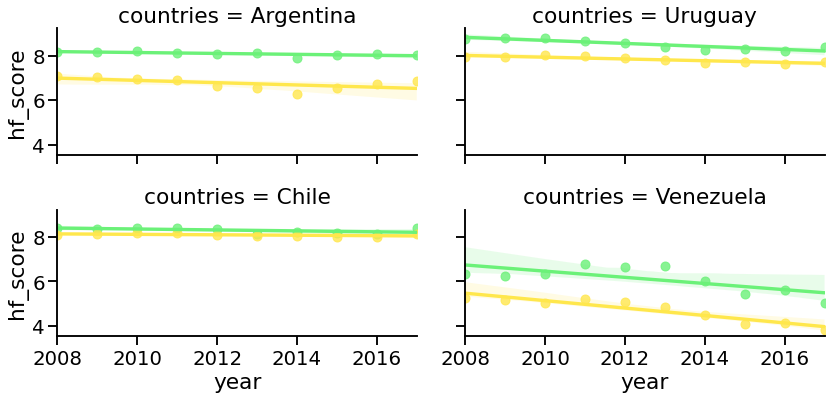

In [71]:
#no entendemos este código
g = seaborn.FacetGrid(dataset, col="countries",
                      margin_titles=True, aspect=2, col_wrap=2,
                      col_order=countries)
g.map(seaborn.regplot,"year", "pf_score", color=GREEN)
g.map(seaborn.regplot,"year", "hf_score", color=YELLOW)
g.set(xlim=(2008, 2017))

print('Tendencias de los puntajes de libertad para América Latina');

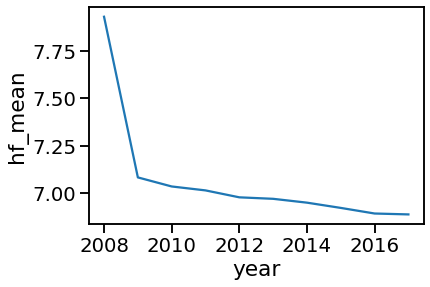

In [72]:
pf_ur, hf_ur = get_means_by_country('Uruguay')
#pf_ur_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_ur)
hf_ur_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_ur)
#ur_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_ur)


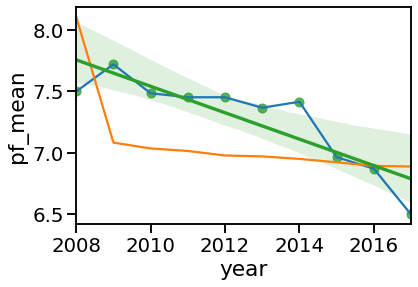

In [35]:
pf_ch, hf_ch = get_means_by_country('Chile')
pf_ch_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_ch)
hf_ch_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_ch)
ch_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_ch)


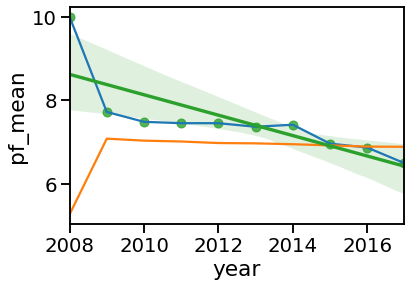

In [36]:
pf_vz, hf_vz = get_means_by_country('Venezuela')
pf_vz_plot = seaborn.lineplot(x="year", y="pf_mean", data=pf_vz)
hf_vz_plot = seaborn.lineplot(x="year", y="hf_mean", data=hf_vz)
vz_tend_pf = seaborn.regplot(x="year",y="pf_mean",data = pf_vz)


## 3. Distribuciones - Karen y Pablo 
  1. Graficar en un mismo histograma la distribución de la variable *pf_identity* en global, y en Latinoamérica y el caribe. Repetir para la variable *hf_score*. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todo el conjunto de valores disponibles para esa region en estos gráficos?


https://relopezbriega.github.io/blog/2016/06/29/distribuciones-de-probabilidad-con-python/

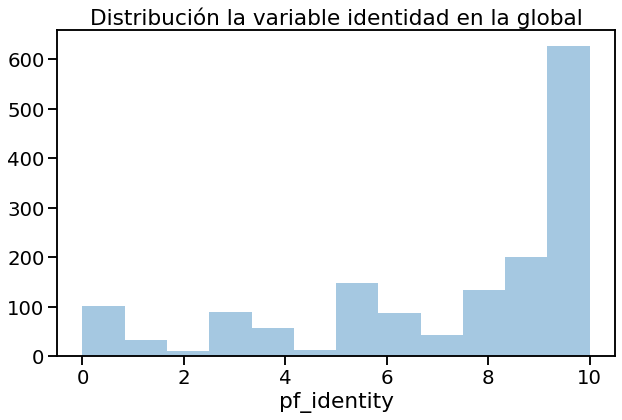

In [58]:
plt.figure(figsize=(10,6))
plt.title('Distribución la variable identidad en la global')
seaborn.distplot(dataset.pf_identity,kde=False)


#### Distribución
Pareciera tener distribución exponencial.
La muestra está concentrada hacia la derecha, es decir, hay una probabilidad más alta, dada una muestra, de encontrarse con una pf_identity con valor alto

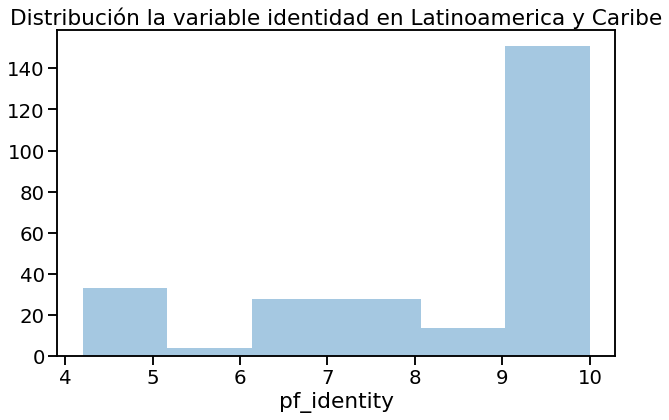

In [59]:
latam = dataset.groupby(['region']).get_group('LatAm')
plt.figure(figsize=(10,6))
plt.title('Distribución la variable identidad en Latinoamerica y Caribe')
seaborn.distplot(latam.pf_identity, kde=False)

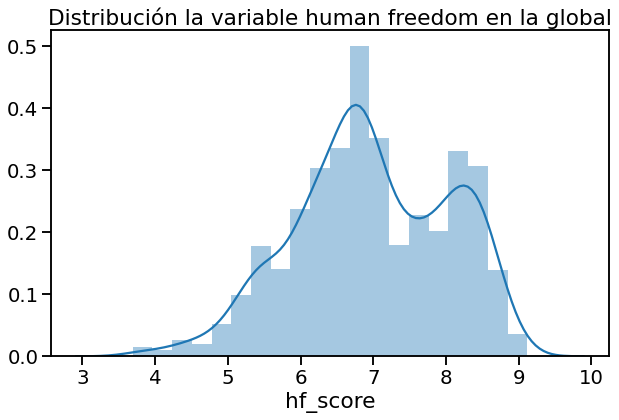

In [39]:
plt.figure(figsize=(10,6))
plt.title('Distribución la variable human freedom en la global')
seaborn.distplot(dataset.hf_score)

#Pareciera ser Chi Cuadrado

#### Distribución
Pareciera tener distribución Chi cuadrado.
Presenta dos copas, un máximo global y uno local.
La muestra está concentrada levemente hacia la derecha, el máximo global se da para un hf_score de aprox 7,
siendo el otro pico alrededor del hf_score aprox 8.

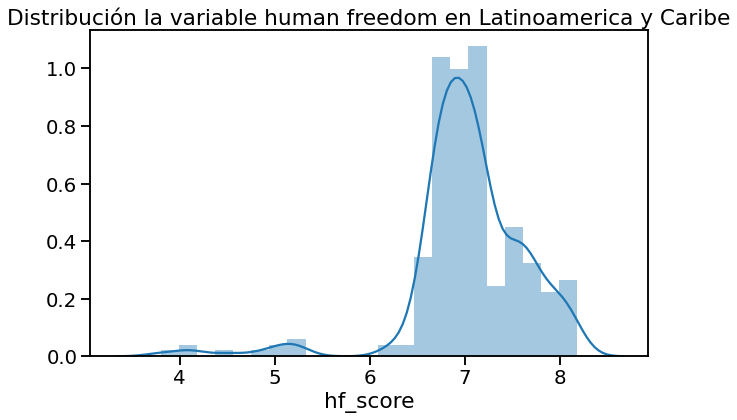

In [40]:
latam = dataset.groupby(['region']).get_group('LatAm')
plt.figure(figsize=(10,6))
plt.title('Distribución la variable human freedom en Latinoamerica y Caribe')
seaborn.distplot(latam.hf_score)

#También pareciera ser Chi cuadrado

#### Distribución
Pareciera tener distribución Chi cuadrado.
Presenta una copita, cerca de hf_score=7
En comparación a la distribución global, presenta un solo pico, y es mucho más pronunciado

## 4. Correlaciones y Relaciones -  Gonzalo

En este ejercicio queremos responder a las preguntas

* Las libertades personales y económicas, ¿van siempre de la mano?
* ¿Cómo se relacionan ambas con las libertades respectivas a las relaciones personales?

Para ello, analizaremos las correlaciones entre las variables pf_identity, pf_score y ef_score. 

Como pf_indentity contribuye al cálculo de pf_score esperamos hallar algún grado de correlación. Lo contrario podría ocurrir con ef_score. 

1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?
2. Graficar la correlación (visual) entre pf_identity y pf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en la práctica, discreta, y eso afecta al tipo de gráfico que podemos usar.
3. Convertir estas variables en categóricas, es decir, a partir de pf_indentity generar otra variable pf_identity_segment que tome los valores `high`, `medium` y `low`. Pueden hacerlo con una función escrita por ustedes, o usando alguna función de pandas como `pandas.cut` o `pandas.dcut`. Repetir para ef_score y pf_score. El criterio para decidir qué intervalos de valores corresponden a cada categoría tienen que decidirlo ustedes, pueden usar los estadísticos mediana y los cuartiles.
4. Graficar la correlación (visual) entre estas tres variables categoricas usando gráficos de calor (heatmaps). Note: van a necesitar 3 gráficos distintos, porque en cada uno podemos incluir sólo 2 variables.



# Parte 2

Luego del segundo fin de semana de clase, podemos revisitar nuestro trabajo anterior y completarlo respondiendo a las siguientes preguntas:

## 3. Distribuciones

2. Realizar una prueba de Kolmogorov-Smirnof para comprobar analíticamente si estas variables responden la distribución propuesta en el ejercicio anterior. Hint: podés usar https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html, pero hay que tener en cuenta que si la distribución es "norm", entonces va a comparar los datos con una distribución normal con media 0 y desviación estándar 1. Se puede utilizar la distribución sobre todos los datos o sólo sobre Latinoamérica.

## 4. Correlaciones

3. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismo. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no. 
4. [Opcional] Analizar la correlación entre la region y el pf_score (y/o el ef_score); y entre la region y el pf_identity. Considerar que como la variable *region* es ordinal, debe utilizarse algún tipo de test. Explicar cuáles son los requisitos necesarios para la aplicación de ese test. (Si no se cumplieran, se pueden agregar algunos datos para generar más registros). Genere nuevas variables categóricas ordinales para calcular la correlación Tau de Kendal y genere una tabla de contingencia con esas nuevas variables.

Además de completar estos puntos faltantes, luego de haber visitado los conceptos de percepción visual y comunicación efectiva, están en condiciones de reveer los gráficos realizados y evaluar si pueden ser mejorados. Para ello, puede hacerse las siguientes preguntas:

* ¿Están utilizando el tipo de gráfico adecuado para cada tipo de variable?
* Los gráficos, ¿son legibles?
* Los gráficos generados, ¿responden a las preguntas mostrando un patrón claro? En caso de que no, ¿podemos filtrar los datos para que el patrón sea más evidente? ¿o agruparlos de manera distinta? ¿o cambiar el tipo de gráfico?